<a href="https://colab.research.google.com/github/gabrielcampanile/Neural-Network/blob/main/Projeto%20Final%20-%20Translator/GRU_translator_EN_PT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tradutor Inglês-Português com Redes Sequência-a-Sequência e Atenção

Este notebook implementa um modelo de tradução automática de inglês para português, baseado no tutorial "NLP From Scratch: Translation with a Sequence to Sequence Network and Attention" do PyTorch.

A arquitetura utilizada é um modelo **Sequence-to-Sequence (Seq2Seq)** composto por um **Encoder** e um **Decoder** com redes neurais recorrentes (GRU). Para melhorar a performance, implementamos um **Mecanismo de Atenção (Attention)**, que permite ao modelo focar em partes específicas da frase de entrada ao gerar a tradução.

**Estratégia Principal:** Para garantir que o treinamento seja computacionalmente viável e rápido, seguimos a orientação de limitar o tamanho do nosso dataset. Em vez de usar todas as frases disponíveis, criamos um vocabulário com as palavras mais frequentes e filtramos o dataset para usar apenas um número limitado de frases que podem ser formadas com esse vocabulário.

-----

In [ ]:
# Para plotagem no notebook
%matplotlib inline

# Imports principais
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import time
import math

# Imports do PyTorch e utilidades
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

# Imports para plotagem
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker

# Configuração do dispositivo (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Tokens especiais para marcar início e fim de sentenças
SOS_token = 0
EOS_token = 1


Usando dispositivo: cuda


## Preparação dos Dados: Classes e Funções de Normalização

Para trabalhar com texto, primeiro precisamos processá-lo.

1.  **Classe `Lang`**: Uma classe auxiliar para criar um vocabulário. Ela mapeia cada palavra única para um índice numérico (e vice-versa) e conta a frequência de cada palavra.
2.  **Normalização de Strings**: Funções para converter o texto para um formato padrão: minúsculas, remoção de acentos e de caracteres especiais. Isso reduz a complexidade do vocabulário.

-----

In [ ]:
# Tokens especiais atualizados
SOS_token = 0
EOS_token = 1
UNK_token = 2 # Novo token para palavras desconhecidas

# Classe Lang atualizada para incluir UNK
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "<UNK>"}
        self.n_words = 3

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Converte uma string Unicode para ASCII puro
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Deixa em minúsculo, remove espaços e caracteres não-letra
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

## Leitura e Filtragem de Dados

Aqui definimos as funções para carregar, processar e preparar o dataset para o treinamento. Esta é a etapa mais customizada do nosso projeto.

1.  `readLangs`: Lê o arquivo de texto `eng-por.txt` e o divide em pares de sentenças.
2.  `prepareDataWithVocabLimit`: Nossa função principal de preparação. Ela lê todos os pares, conta a frequência das palavras, cria vocabulários com as `N` palavras mais comuns, e então filtra o dataset para manter apenas um número limitado de frases curtas que usam exclusivamente palavras desses vocabulários.
3.  `get_dataloader`: Junta tudo, executa a preparação e cria um `DataLoader` do PyTorch, que nos ajudará a alimentar o modelo com dados em lotes (batches) de forma eficiente.

-----

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Lendo as linhas...")
    # Assumimos que o arquivo limpo está em 'data/eng-por.txt'
    lines = open(f'data/{lang1}-{lang2}.txt', encoding='utf-8').read().strip().split('\n')

    pairs = []
    for l in lines:
      line_parts = l.split('\t')
      if len(line_parts) == 2:
        pairs.append([normalizeString(s) for s in line_parts])

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

def prepareDataWithVocabLimit(lang1, lang2, reverse=False, max_vocab_size=4000, max_pairs=None):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print(f"Lidos {len(pairs)} pares de sentenças")

    temp_input_lang = Lang(input_lang.name)
    temp_output_lang = Lang(output_lang.name)
    for pair in pairs:
        temp_input_lang.addSentence(pair[0])
        temp_output_lang.addSentence(pair[1])
    print("Contagem de palavras completa.")

    sorted_input_vocab = sorted(temp_input_lang.word2count.items(), key=lambda item: item[1], reverse=True)
    sorted_output_vocab = sorted(temp_output_lang.word2count.items(), key=lambda item: item[1], reverse=True)

    input_lang = Lang(input_lang.name)
    output_lang = Lang(output_lang.name)
    for word, _ in sorted_input_vocab[:max_vocab_size-2]:
        input_lang.addWord(word)
    for word, _ in sorted_output_vocab[:max_vocab_size-2]:
        output_lang.addWord(word)
    print(f"Vocabulário limitado criado. Input: {input_lang.n_words} palavras, Output: {output_lang.n_words} palavras.")

    filtered_pairs = []
    for pair in pairs:
        if len(pair[0].split(' ')) >= MAX_LENGTH or len(pair[1].split(' ')) >= MAX_LENGTH:
            continue
        input_valid = all(word in input_lang.word2index for word in pair[0].split(' '))
        output_valid = all(word in output_lang.word2index for word in pair[1].split(' '))
        if input_valid and output_valid:
            filtered_pairs.append(pair)

    if max_pairs:
        random.shuffle(filtered_pairs)
        filtered_pairs = filtered_pairs[:max_pairs]

    print(f"Dataset final com {len(filtered_pairs)} pares de sentenças.")
    return input_lang, output_lang, filtered_pairs

def get_dataloader(batch_size, lang1, lang2, device, max_vocab_size=4000, max_pairs=None, reverse=True):
    input_lang, output_lang, pairs = prepareDataWithVocabLimit(lang1, lang2, reverse, max_vocab_size, max_pairs)
    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = [input_lang.word2index[word] for word in inp.split(' ')]
        tgt_ids = [output_lang.word2index[word] for word in tgt.split(' ')]
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader, pairs

## A Arquitetura do Modelo: Seq2Seq com Atenção

#### Encoder

O `EncoderRNN` processa a frase de entrada e a comprime em um vetor de contexto. Ele usa uma camada de *Embedding* para transformar os índices das palavras em vetores densos, e uma camada *GRU* para processar a sequência.

#### Attention Decoder

O `AttnDecoderRNN` gera a frase de saída. A cada passo, ele usa o mecanismo `BahdanauAttention` para calcular pesos de atenção, criando um vetor de contexto ponderado que foca nas partes mais relevantes da entrada. Este contexto é combinado com a palavra anterior para prever a próxima palavra da tradução.

-----

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)
        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))
        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)
        return output, hidden, attn_weights

## Treinamento do Modelo

Definimos agora as funções para treinar nosso modelo.

  - `train_epoch`: Executa uma única época de treinamento. Para cada lote de dados, ela passa as frases pelo encoder e decoder, calcula a perda (o quão errada a previsão foi) e atualiza os pesos das redes usando os otimizadores.
  - `train`: Orquestra o processo de treinamento completo por várias épocas, chamando `train_epoch` repetidamente. Ela também monitora a perda, exibe o progresso e o tempo decorrido.
  - `asMinutes` e `timeSince`: Funções auxiliares para formatar o tempo de treinamento.

-----

In [ ]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001, print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print("=" * 50)
            print(f"⏳ Tempo decorrido: {timeSince(start, epoch / n_epochs)}")
            print(f"📅 Época: {epoch}/{n_epochs} ({epoch / n_epochs * 100:.2f}%)")
            print(f"📉 Loss médio: {print_loss_avg:.4f}")
            print("=" * 50 + "\n")

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## Plotando os Resultados

Uma função simples para plotar a perda (loss) ao longo do treinamento. Ver a perda diminuir é um bom sinal de que o modelo está aprendendo.

-----

In [ ]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.xlabel("Épocas (x100)")
    plt.ylabel("Perda (Loss)")
    plt.show()

## Avaliação e Visualização

Após o treinamento, precisamos de funções para testar nosso modelo.

  - `evaluate`: Recebe uma frase em português, a traduz para o inglês e retorna a tradução.
  - `evaluateRandomly`: Pega `n` frases aleatórias do nosso dataset de teste, exibe a entrada, o alvo (tradução correta) e a saída do modelo (tradução prevista). É ótima para uma avaliação qualitativa rápida.

-----

In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        # Converte a sentença de entrada em um tensor de índices.
        # Se uma palavra não for encontrada, usa o UNK_token.
        input_indices = [input_lang.word2index.get(word, UNK_token) for word in sentence.split(' ')]
        input_indices.append(EOS_token)
        input_tensor = torch.tensor(input_indices, dtype=torch.long, device=device).view(1, -1)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            # O output não precisa de UNK, pois ele sempre gera palavras de seu vocabulário
            decoded_words.append(output_lang.index2word[idx.item()])

    return decoded_words, decoder_attn

def evaluateRandomly(encoder, decoder, pairs, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Executando o Treinamento

Tudo pronto\! Nesta célula, definimos os hiperparâmetros finais (tamanho da camada oculta, tamanho do lote, etc.), chamamos nossa função `get_dataloader` para preparar os dados e, finalmente, iniciamos o treinamento com a função `train`.

-----

Lendo as linhas...
Lidos 196350 pares de sentenças
Contagem de palavras completa.
Vocabulário limitado criado. Input: 1001 palavras, Output: 1001 palavras.
Dataset final com 10000 pares de sentenças.
⏳ Tempo decorrido: 0m 40s (- 4m 42s)
📅 Época: 5/40 (12.50%)
📉 Loss médio: 1.1729

⏳ Tempo decorrido: 1m 21s (- 4m 3s)
📅 Época: 10/40 (25.00%)
📉 Loss médio: 0.2252

⏳ Tempo decorrido: 2m 3s (- 3m 25s)
📅 Época: 15/40 (37.50%)
📉 Loss médio: 0.0954

⏳ Tempo decorrido: 2m 43s (- 2m 43s)
📅 Época: 20/40 (50.00%)
📉 Loss médio: 0.0591

⏳ Tempo decorrido: 3m 24s (- 2m 2s)
📅 Época: 25/40 (62.50%)
📉 Loss médio: 0.0443

⏳ Tempo decorrido: 4m 6s (- 1m 22s)
📅 Época: 30/40 (75.00%)
📉 Loss médio: 0.0361

⏳ Tempo decorrido: 4m 47s (- 0m 41s)
📅 Época: 35/40 (87.50%)
📉 Loss médio: 0.0311

⏳ Tempo decorrido: 5m 27s (- 0m 0s)
📅 Época: 40/40 (100.00%)
📉 Loss médio: 0.0299



<Figure size 640x480 with 0 Axes>

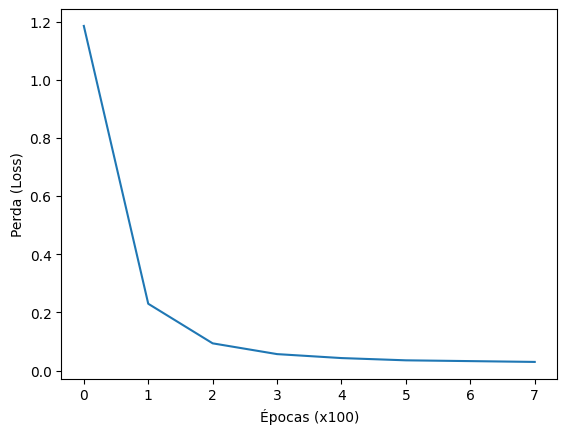

<Figure size 640x480 with 0 Axes>

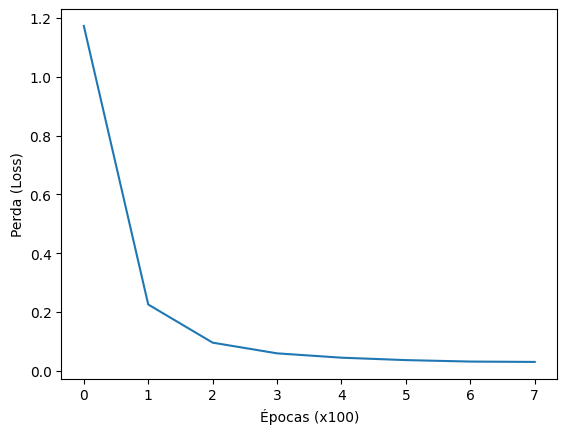

In [ ]:
# --- Bloco de código para iniciar o treinamento ---

# Defina os hiperparâmetros
hidden_size = 256
batch_size = 32
MAX_LENGTH = 10        # Frases com até 10 palavras (incluindo pontuação)
MAX_VOCAB_SIZE = 1000  # Limite de 1000 palavras mais comuns
MAX_PAIRS = 10000      # Limite de 10.000 frases para treinar

# Carrega os dados usando a nossa função customizada
# lang1='eng', lang2='por', reverse=True -> para traduzir de POR para ENG
# A variável 'pairs' é retornada para ser usada na avaliação
input_lang, output_lang, train_dataloader, pairs = get_dataloader(
    batch_size,
    'por',
    'eng',
    device,
    max_vocab_size=MAX_VOCAB_SIZE,
    max_pairs=MAX_PAIRS,
    reverse=False
)

# Inicializa os modelos
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

# Inicia o treinamento
train(train_dataloader, encoder, decoder, n_epochs=40, print_every=5, plot_every=5)


## Avaliando o modelo

Após o término do treinamento, mudamos os modelos para o modo de avaliação (`.eval()`) e chamamos `evaluateRandomly` para ver alguns resultados.

-----

In [ ]:
# Avalia resultados aleatórios
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder, pairs)

> tom sempre foi bom no beisebol .
= tom has always been good at baseball .
< tom has always been good at baseball . <EOS>

> quem e o proximo da lista ?
= who s next on the list ?
< who s next on the list ? <EOS>

> eu sou alto .
= i am tall .
< i am tall . <EOS>

> estas seguro agora .
= you re safe now .
< are you safe now . <EOS>

> eu tenho que estudar frances .
= i have to study french .
< i have to study french . <EOS>

> ele provavelmente nao vira .
= he probably won t come .
< he probably won t come . <EOS>

> nao se esqueca disso .
= don t forget this .
< don t forget this . <EOS>

> tom quer falar com maria .
= tom wants to talk to mary .
< tom wants to talk to mary . <EOS>

> as criancas precisam de sono .
= kids need sleep .
< kids need sleep need sleep . <EOS>

> voce precisa de quantas horas de sono ?
= how many hours of sleep do you need ?
< how many hours of sleep do you need ? <EOS>



## Métricas de Desempenho: Calculando o BLEU Score

A métrica mais comum para tradução automática é o **BLEU (Bilingual Evaluation Understudy)**. De forma simples, o BLEU compara a tradução gerada pelo seu modelo com uma ou mais traduções humanas de referência. Ele gera uma pontuação de 0 a 1 (ou 0 a 100), onde valores mais altos indicam que a tradução do modelo é mais similar à tradução de referência.

-----

In [ ]:
!pip install sacrebleu

In [ ]:
import sacrebleu

def calculate_bleu_with_sacrebleu(pairs, encoder, decoder, input_lang, output_lang):
    """
    Calcula a pontuação BLEU usando a biblioteca externa sacrebleu.
    """
    print("Calculando a pontuação BLEU com sacrebleu...")

    # sacrebleu espera listas de sentenças (strings), não de tokens
    candidates = []
    references = []

    for pair in pairs:
        source_sentence = pair[0]
        # A referência já é uma string, que é o que precisamos
        reference_sentence = pair[1]

        # Gera a tradução (candidata) com o modelo
        output_words, _ = evaluate(encoder, decoder, source_sentence, input_lang, output_lang)

        if output_words[-1] == '<EOS>':
            output_words = output_words[:-1]

        # Junta os tokens da candidata em uma única string
        candidate_sentence = ' '.join(output_words)

        candidates.append(candidate_sentence)
        references.append(reference_sentence)

    # A API do sacrebleu espera a lista de referências dentro de outra lista,
    # pois suporta múltiplas referências por sentença.
    # A pontuação já vem na escala de 0 a 100.
    bleu = sacrebleu.corpus_bleu(candidates, [references])

    print(f"Pontuação BLEU (sacrebleu): {bleu.score:.2f}")

    return bleu.score

In [ ]:
bleu_value = calculate_bleu_with_sacrebleu(pairs, encoder, decoder, input_lang, output_lang)

Calculando a pontuação BLEU com sacrebleu...


Pontuação BLEU (sacrebleu): 91.52


In [ ]:
# Salva apenas os pesos (o dicionário de estado)
torch.save(encoder.state_dict(), 'gru_encoder_pesos.pth')
torch.save(decoder.state_dict(), 'gru_decoder_pesos.pth')

print("Pesos do modelo GRU salvos com sucesso!")

# Salva o modelo completo
torch.save(encoder, 'gru_encoder_completo.pth')
torch.save(decoder, 'gru_decoder_completo.pth')

print("Modelo GRU completo salvo com sucesso!")

Pesos do modelo GRU salvos com sucesso!
Modelo GRU completo salvo com sucesso!
